In [3]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Parameters
hbar = 1 
sigma = (hbar/2) * np.eye(2)  # Covariance matrix
inv_sigma = np.linalg.inv(sigma)
det_sigma = np.linalg.det(2*np.pi*sigma)

# Create grid
x = np.linspace(-5, 5, 100)
p = np.linspace(-5, 5, 100)
X, P = np.meshgrid(x, p)
grid_points = np.stack([X.ravel(), P.ravel()], axis=-1)


# Gaussian Distributino
def GaussianDistribution(diff, det, inv_cov):
    
    # Calculate the exponent for all points at once
    exponent = -0.5 * np.einsum('ni,ij,nj->n', diff, inv_cov, diff)
    
    return (1/(2*np.pi * np.sqrt(det))) * np.exp(exponent)

# Passing Along
def WignerCalc(diff, det, inv_cov):
    return GaussianDistribution(diff, det, inv_cov).reshape(X.shape)

# Gaussians
$$
\begin{align}
    G_{\mu, \sigma} &= \frac{1}{\sqrt{\text{det}(2\pi\sigma)}} e^{\frac{-1}{2}(q-\mu)^T \sigma^{-1}(q-\mu)} \\
    W_{|\alpha\rangle\langle \alpha|}(q) &= G_{\mu, \sigma}
\end{align}
$$
# Superposition of Gaussians

$$\begin{align}
    |\psi\rangle \langle \psi| &= \hat{S}(z) \sum_{k,l}^{n} |\alpha_k\rangle\langle\alpha_l| \hat{S}^\dagger (z)  \\
    W(q) &= \sum_{k,l} e^{c_{k,l}} G_{\mu_{k,l},\sigma_{k,l}} (q) \\
    W(q) &= \sum_k e^{c_{k,k}} G_{\mu_{k,k},\sigma} (q) + 2 \text{Re} \left(\sum_{l>k} e^{c_{k,l}} G_{\mu_{k,l},\sigma}(q) \right) \\
    c_{k,l} &= \ln(a_k) + \ln(a_l^*) + d_{k,l} \\
    d_{k,l} &= \frac{-1}{2} \text{Im}(\alpha_k - \alpha_l)^2 - i\text{Im}(\alpha_l)\text{Re}(\alpha_k) - \frac{1}{2} \text{Re}(\alpha_k - \alpha_l)^2 - i\text{Im}(\alpha_k)\text{Re}(\alpha_l) \\
    \mu_{k,l} &= \sqrt{\frac{\hbar}{2}} \begin{pmatrix} \text{Re}(\alpha_k + \alpha_l) + i\text{Im}(\alpha_k - \alpha_l) \\ \text{Im}(\alpha_k + \alpha_l) - i\text{Re}(\alpha_k - \alpha_l) \end{pmatrix} \\
    N &= \sum_k e^{c_{k,k}} + 2 \text{Re}\left( \sum_{l>k} e^{c_{k,l}} \right) 
\end{align}$$

# Fock state as a superposition of Gaussian states
$$
\begin{align}
    |n\rangle\langle n| &\approx \frac{1}{N} \sum^n_{k,l} c_k c_l |\alpha_k\rangle \langle \alpha_l | \\
    c_k &= e^{-2i\pi kn/(n+1)} \\
    \alpha_k &= \epsilon e^{2\pi ik/(n+1)} \\
    w_{k,l} &= d_{k,l} - \frac{2\pi i (k-1)n}{n+1} \\
    W_{|n\rangle\langle n|}(q) &= \sum^n_{k,l = 0} e^{w_{k,l}} G_{\mu_{k,l},\frac{\hbar}{2}I}(q)
\end{align}
$$

# Superposition of Fock states as a superposition of Gaussian states
$$
\begin{align}
    |\psi\rangle &= \sum^n_{l=0} a_l |l\rangle \approx \sum^n_{k=0} c_k |\alpha_k \rangle \\
    c_k &= \sum^n_{l=0} \sqrt(l!) \frac{a_l}{\epsilon^l} e^{-2\pi ikl/(n+1)} \\
    \alpha_k &= \epsilon e^{2\pi ik/(n+1)} \\
    W_{|\psi\rangle\langle \psi|}(q) &= \sum^n_{k,l = 0} e^{w_{k,l}} G_{\mu_{k,l},\frac{\hbar}{2}I}(q)
\end{align}
$$

# Plotting Coherent State Superposition (Even Cat State)

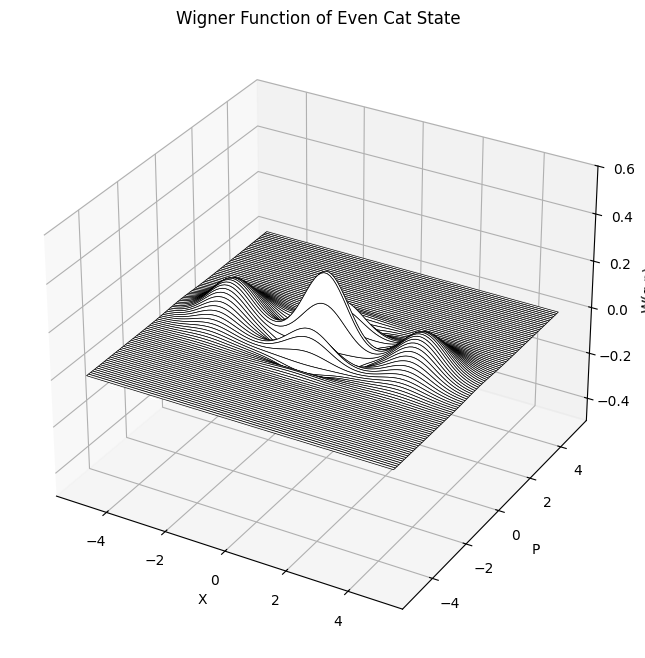

In [4]:
alpha = np.sqrt(5)

# Normalization factor for even cat state
Ne = 1/np.sqrt(2*(1 + np.exp(-2*np.abs(alpha)**2)))


# Define all possible combinations (including cross terms)
states = [alpha, -alpha]  # |α⟩ and |-α⟩
n_terms = len(states)


# Calculate all μ_{kl} and c_{kl}
mu = np.zeros((n_terms, n_terms, 2), dtype=complex)
d = np.zeros((n_terms, n_terms), dtype=complex)
c = np.zeros((n_terms, n_terms), dtype=complex)

for k in range(n_terms):
    for l in range(n_terms):
        # Calculate μ_{kl} 
        sum_states = states[k] + states[l]
        diff_states = states[k] - states[l]
        mu[k,l] = np.sqrt(hbar/2) * np.array([
            sum_states.real + 1j*diff_states.imag,
            sum_states.imag + 1j*(-diff_states.real)
        ])
        
        # Calculate d_{kl}
        d[k,l] = ( -0.5*diff_states.imag**2 - 0.5*diff_states.real**2
                  - 1j*states[l].imag*states[k].real + 1j*states[k].imag*states[l].real)
        
        # Slightly modified c_m
        c[k,l] = np.log(Ne) + np.log(Ne) + d[k,l]

# Compute Wigner function components
W1 = np.zeros_like(X, dtype=complex)

for k in range(n_terms):
    for l in range(k, n_terms):  # Only compute upper triangle
        diff = grid_points - mu[k,l]  # Take real part for displacement
        exponent = -0.5 * np.einsum("ni,ij,nj->n...", diff , inv_sigma , diff)
        G = (1/np.sqrt((det_sigma))) * np.exp(exponent).reshape(X.shape)
        
        if k == l:  # Diagonal terms
            W1 += np.exp(c[k,l]) * G
        else:  # Cross terms (include factor of 2 for Re)
            W1 += 2 * (np.exp(c[k,l]) * G).real

# Take real part and normalize
N = np.sum(np.exp(c)).real
W1 = W1/N

# Plotting
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, P, W1, rstride=1, cstride=100000, color='w', edgecolor='k', shade=False, lw=.5, alpha=1)


ax.set_xlabel('X')
ax.set_ylabel('P')
ax.set_zlabel('W(q,p)')
ax.set_title('Wigner Function of Even Cat State')
ax.set_zlim(-0.5, 0.6)
plt.show()

# Plotting Fock states

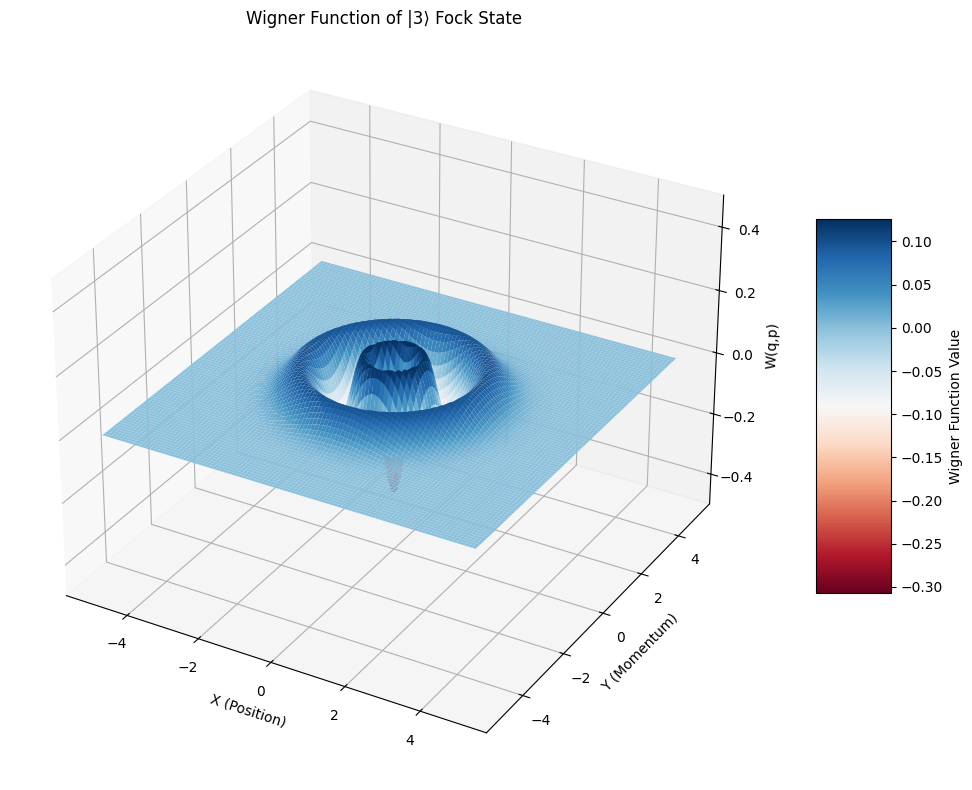

In [5]:
# Fock state number
n = 3

# Calculate all μ_{kl} and c_{kl}
states = np.zeros(n+1, dtype=complex)  # The alpha's that we need to approx. the fock for
n_terms = len(states)
mu = np.zeros((n_terms, n_terms, 2), dtype=complex)
d = np.zeros((n_terms, n_terms), dtype=complex)
w = np.zeros((n_terms, n_terms), dtype=complex)
c = np.zeros(n+1, dtype=complex)

epsilon = 0.1


# Calculating necessary alphas and coefficients c_k
for k in range(n+1):
    states[k] = epsilon * np.exp( (2*np.pi*1j*k) / (n+1) )
    c[k] = np.exp((-2*np.pi*1j*k*n) / (n+1) )

# Now calculating the mu_kl, d_kl, w_kl
for k in range(n_terms):
    for l in range(n_terms):
        # Calculate μ_{kl} 
        sum_states = states[k] + states[l]
        diff_states = states[k] - states[l]
        mu[k,l] = np.sqrt(hbar/2) * np.array([
            sum_states.real + 1j*diff_states.imag,
            sum_states.imag + 1j*(-diff_states.real)
        ])
        
        # Calculate d_{kl}
        d[k,l] = ( -0.5*diff_states.imag**2 - 0.5*diff_states.real**2
                  - 1j*states[l].imag*states[k].real + 1j*states[k].imag*states[l].real)
        
        # Calculate w_kl
        w[k,l] = d[k,l] - (2*np.pi*1j*(k-l)*n) / (n+1)

# Normalization constant
N = np.sum(np.exp(w))

# Calculating the Wigner function
W_Fock = np.zeros_like(X, dtype=complex)

for k in range(n_terms):
    for l in range(k, n_terms):  # Only compute upper triangle
        diff = grid_points - mu[k,l]  # Take real part for displacement
        exponent = -0.5 * np.einsum("ni,ij,nj->n...", diff , inv_sigma , diff)
        G = (1/np.sqrt((det_sigma))) * np.exp(exponent).reshape(X.shape)
        
        if k == l:  # Diagonal terms
            W_Fock += np.exp(w[k,l]) * G
        else:  # Cross terms (include factor of 2 for Re)
            W_Fock += 2 * (np.exp(w[k,l]) * G).real

W_Fock = W_Fock / N

# Plotting
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Use proper surface plotting with colormap to show negativity
surf = ax.plot_surface(X, P, W_Fock, cmap='RdBu', 
                      rstride=1, cstride=1,
                      edgecolor='none', 
                      antialiased=True)

ax.set_xlabel('X (Position)')
ax.set_ylabel('Y (Momentum)')
ax.set_zlabel('W(q,p)')
ax.set_title(f'Wigner Function of |{n}⟩ Fock State')
ax.set_zlim(-0.5, 0.5)  # Adjusted for better view of negativity

# Add colorbar to show negative values
fig.colorbar(surf, shrink=0.5, aspect=5, label='Wigner Function Value')
plt.tight_layout()
plt.show()

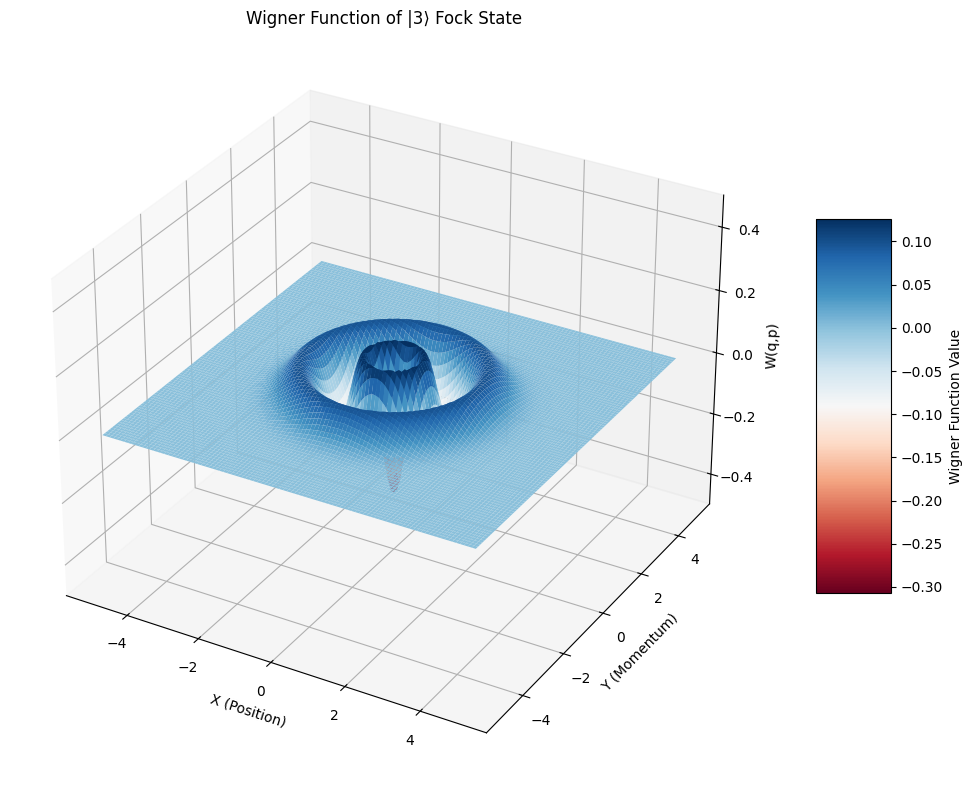

In [ ]:
import scipy as sp
from scipy.special import eval_laguerre 

def wigner_fock(n, x, y):
    factor1 = ((-1)**n)/np.pi 
    factor2 = np.exp(-x**2 - y**2)
    L = eval_laguerre(n, 2*x**2 + 2*y**2) 
    return factor1 * factor2 * L


W_fock_ref = wigner_fock(n, X, P)

# Plotting
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Use proper surface plotting with colormap to show negativity
surf = ax.plot_surface(X, P, W_fock_ref, cmap='RdBu', 
                      rstride=1, cstride=1,
                      edgecolor='none', 
                      antialiased=True)

ax.set_xlabel('X (Position)')
ax.set_ylabel('Y (Momentum)')
ax.set_zlabel('W(q,p)')
ax.set_title(f'Wigner Function of |{n}⟩ Fock State')
ax.set_zlim(-0.5, 0.5)  # Adjusted for better view of negativity

# Add colorbar to show negative values
fig.colorbar(surf, shrink=0.5, aspect=5, label='Wigner Function Value')
plt.tight_layout()
plt.show()

# Superposition of Fock States (Normalized GKP?)

$|0\rangle \approx \hat{S}(0.196) \left( 0.661 |0\rangle - 0.343|2\rangle + 0.253|4\rangle - 0.368 |6\rangle + 0.377|8\rangle + 0.323 |10\rangle + 0.365|12\rangle \right) $

Taken from: https://the-walrus.readthedocs.io/en/latest/gallery/gkp.html

In [7]:
psi = [ 0.661, 0, -0.343, 0, 0.253, 0, -0.368, 0, 0.377, 0, 0.323, 0, 0.365 ] # In Fock basis
psi = psi / np.linalg.norm(psi)

# Calculate all μ_{kl} and c_{kl}
states = np.zeros(len(psi), dtype=complex) # Holds the alpha's
n_terms = len(psi) # n+1 terms
n = len(psi) - 1 # Max number of photons
mu = np.zeros((n_terms, n_terms, 2), dtype=complex)
d = np.zeros((n_terms, n_terms), dtype=complex)
w = np.zeros((n_terms, n_terms), dtype=complex)
c = np.zeros(n_terms, dtype=complex)

epsilon = 7

In [8]:
# Calculating necessary alphas and coefficients c_k
for k in range(n_terms):
    states[k] = epsilon * np.exp( (2*np.pi*1j*k) / (n+1) )
    for l in range(n_terms):
        c[k] +=  np.sqrt(sp.special.factorial(l))* ( psi[l] / (epsilon**l) ) * np.exp((-2*np.pi*1j*k*l) / (n+1) )

In [9]:
# Now calculating the mu_kl, d_kl, w_kl
for k in range(n_terms):
    for l in range(n_terms):
        # Calculate μ_{kl} 
        sum_states = states[k] + states[l]
        diff_states = states[k] - states[l]
        mu[k,l] = np.sqrt(hbar/2) * np.array([
            sum_states.real + 1j*diff_states.imag,
            sum_states.imag + 1j*(-diff_states.real)
        ])
        
        # Calculate d_{kl}
        d[k,l] = ( -0.5*diff_states.imag**2 - 0.5*diff_states.real**2
                  - 1j*states[l].imag*states[k].real + 1j*states[k].imag*states[l].real)
        
        # Calculate w_kl
        w[k,l] = d[k,l] - (2*np.pi*1j*(k-l)*n) / (n+1)
# Normalization constant
N = np.sum(np.exp(w))

In [10]:
from ipywidgets import interact, FloatSlider, IntSlider

In [ ]:
def plot_wigner(epsilon):
    psi = [ 0.661, 0, -0.343, 0, 0.253, 0, -0.368, 0, 0.377, 0, 0.323, 0, 0.365 ] # In Fock basis
    psi = psi / np.linalg.norm(psi)

    # Calculate all μ_{kl} and c_{kl}
    states = np.zeros(len(psi), dtype=complex) # Holds the alpha's
    n_terms = len(psi) # n+1 terms
    n = len(psi) - 1 # Max number of photons
    mu = np.zeros((n_terms, n_terms, 2), dtype=complex)
    d = np.zeros((n_terms, n_terms), dtype=complex)
    w = np.zeros((n_terms, n_terms), dtype=complex)
    c = np.zeros(n_terms, dtype=complex)

    # Calculating necessary alphas and coefficients c_k
    for k in range(n_terms):
        states[k] = epsilon * np.exp( (2*np.pi*1j*k) / (n+1) )
        for l in range(n_terms):
            c[k] +=  np.sqrt(sp.special.factorial(l))* ( psi[l] / (epsilon**l) ) * np.exp((-2*np.pi*1j*k*l) / (n+1) )

    # Now calculating the mu_kl, d_kl, w_kl
    for k in range(n_terms):
        for l in range(n_terms):
            # Calculate μ_{kl} 
            sum_states = states[k] + states[l]
            diff_states = states[k] - states[l]
            mu[k,l] = np.sqrt(hbar/2) * np.array([
                sum_states.real + 1j*diff_states.imag,
                sum_states.imag + 1j*(-diff_states.real)
            ])
            
            # Calculate d_{kl}
            d[k,l] = ( -0.5*diff_states.imag**2 - 0.5*diff_states.real**2
                    - 1j*states[l].imag*states[k].real + 1j*states[k].imag*states[l].real)
            
            # Calculate w_kl
            w[k,l] = d[k,l] - (2*np.pi*1j*(k-l)*n) / (n+1)
    # Normalization constant
    N = np.sum(np.exp(w))

    # Calculating the Wigner function
    W_GKP = np.zeros_like(X, dtype=complex)

    for k in range(n_terms):
        for l in range(k, n_terms):  # Only compute upper triangle
            diff = grid_points - mu[k,l] # r - mu
            exponent = -0.5 * np.einsum("ni,ij,nj->n...", diff , inv_sigma , diff)
            G = (1/np.sqrt(det_sigma)) * np.exp(exponent).reshape(X.shape)
            W_GKP += np.exp(w[k,l])*G

    W_GKP = W_GKP / N

    # Plotting
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Use proper surface plotting with colormap to show negativity
    surf = ax.plot_surface(X, P, W_GKP, cmap='RdBu', 
                        rstride=1, cstride=1,
                        edgecolor='none', 
                        antialiased=True)

    ax.set_xlabel('X (Position)')
    ax.set_ylabel('Y (Momentum)')
    ax.set_zlabel('W(q,p)')
    ax.set_title(f'Wigner Function of Some Superposition state')
    ax.set_zlim(-0.5, 0.5)

    # Add colorbar to show negative values
    fig.colorbar(surf, shrink=0.5, aspect=5, label='Wigner Function Value')
    plt.tight_layout()
    plt.show()

interact(
    plot_wigner,
    epsilon=FloatSlider(value=0.1, min=0.1, max=20, step=0.1, description='epsilon:'),
)

interactive(children=(FloatSlider(value=0.1, description='epsilon:', max=20.0, min=0.1), Output()), _dom_class…

<function __main__.plot_wigner(epsilon)>

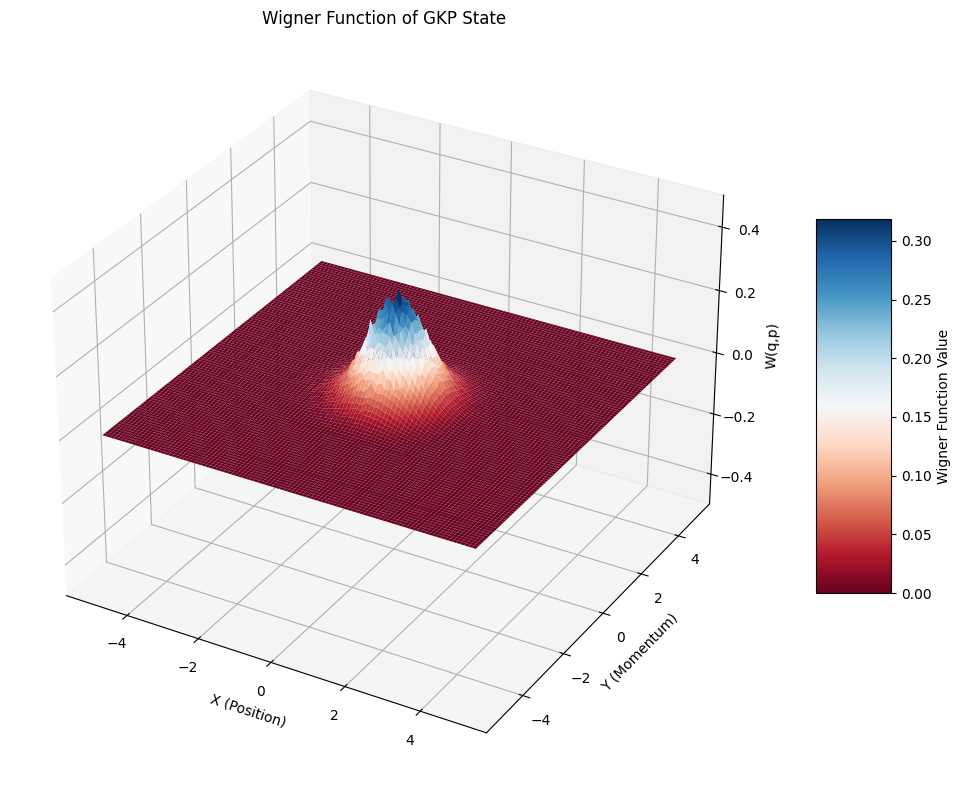

In [ ]:
# Calculating the Wigner function
W_GKP = np.zeros_like(X, dtype=complex)

for k in range(n_terms):
    for l in range(k, n_terms):  # Only compute upper triangle
        diff = grid_points - mu[k,l] # r - mu
        exponent = -0.5 * np.einsum("ni,ij,nj->n...", diff , inv_sigma , diff)
        G = (1/np.sqrt(det_sigma)) * np.exp(exponent).reshape(X.shape)
        
        if k == l:  # Diagonal terms
            W_GKP += np.exp(w[k,l]) * G
        else:  # Cross terms (include factor of 2 for Re)
            W_GKP += 2 * (np.exp(w[k,l]) * G).real

W_GKP = W_GKP / N

# Plotting
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Use proper surface plotting with colormap to show negativity
surf = ax.plot_surface(X, P, W_GKP, cmap='RdBu', 
                      rstride=1, cstride=1,
                      edgecolor='none', 
                      antialiased=True)

ax.set_xlabel('X (Position)')
ax.set_ylabel('Y (Momentum)')
ax.set_zlabel('W(q,p)')
ax.set_title(f'Wigner Function of GKP State')
ax.set_zlim(-0.5, 0.5)

# Add colorbar to show negative values
fig.colorbar(surf, shrink=0.5, aspect=5, label='Wigner Function Value')
plt.tight_layout()
plt.show()

c:\Users\liqiz\Desktop\Semester 3\Scientific Computing in Quantum Information Science\CV_Simulation\.venv\Lib\site-packages\matplotlib\contour.py:1364: ComplexWarning: Casting complex values to real discards the imaginary part
  self.zmax = z.max().astype(float)
c:\Users\liqiz\Desktop\Semester 3\Scientific Computing in Quantum Information Science\CV_Simulation\.venv\Lib\site-packages\matplotlib\contour.py:1365: ComplexWarning: Casting complex values to real discards the imaginary part
  self.zmin = z.min().astype(float)
c:\Users\liqiz\Desktop\Semester 3\Scientific Computing in Quantum Information Science\CV_Simulation\.venv\Lib\site-packages\numpy\ma\core.py:2892: ComplexWarning: Casting complex values to real discards the imaginary part
  _data = np.array(data, dtype=dtype, copy=copy,


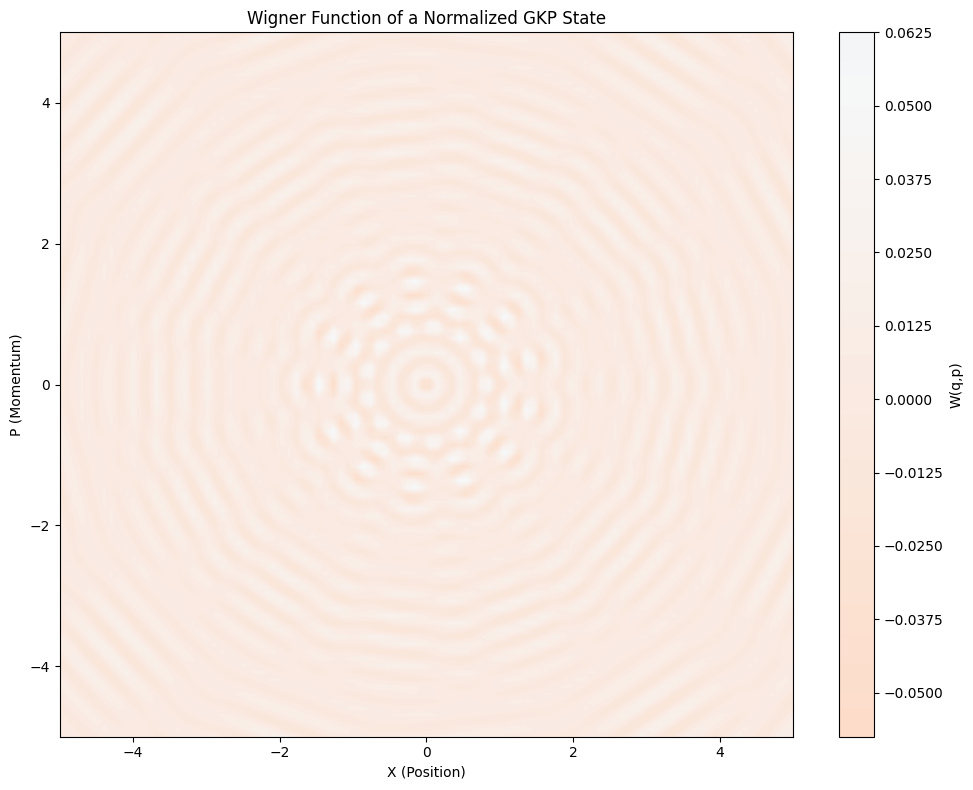

In [ ]:
plt.figure(figsize=(10, 8))
contour = plt.contourf(X, P, W_GKP, levels=50, cmap='RdBu', vmin=-0.5, vmax=0.6)
cbar = plt.colorbar(contour)
cbar.set_label('W(q,p)')
plt.xlabel('X (Position)')
plt.ylabel('P (Momentum)')
plt.title('Wigner Function of a Normalized GKP State')

plt.tight_layout()
plt.show()